
📊 Processing IOWait with Isolation Forest:
  🔍 CPU STRESS:
    ✅ Cleaned 24 outliers (5% contamination rate)
  🔍 BASELINE:
    ✅ Cleaned 24 outliers (5% contamination rate)

📊 Processing IRQ with Isolation Forest:
  🔍 CPU STRESS:
    ✅ Cleaned 22 outliers (5% contamination rate)
  🔍 BASELINE:
    ✅ Cleaned 22 outliers (5% contamination rate)

📊 Processing System with Isolation Forest:
  🔍 CPU STRESS:
    ✅ Cleaned 22 outliers (5% contamination rate)
  🔍 BASELINE:
    ✅ Cleaned 24 outliers (5% contamination rate)

📊 Processing User with Isolation Forest:
  🔍 CPU STRESS:
    ✅ Cleaned 22 outliers (5% contamination rate)
  🔍 BASELINE:
    ✅ Cleaned 25 outliers (5% contamination rate)

📊 Processing Utilization with Isolation Forest:
  🔍 CPU STRESS:
    ✅ Cleaned 22 outliers (5% contamination rate)
  🔍 BASELINE:
    ✅ Cleaned 22 outliers (5% contamination rate)

COMPREHENSIVE CPU STRESS ANALYSIS - ISOLATION FOREST

🔄 Analyzing IOWait...


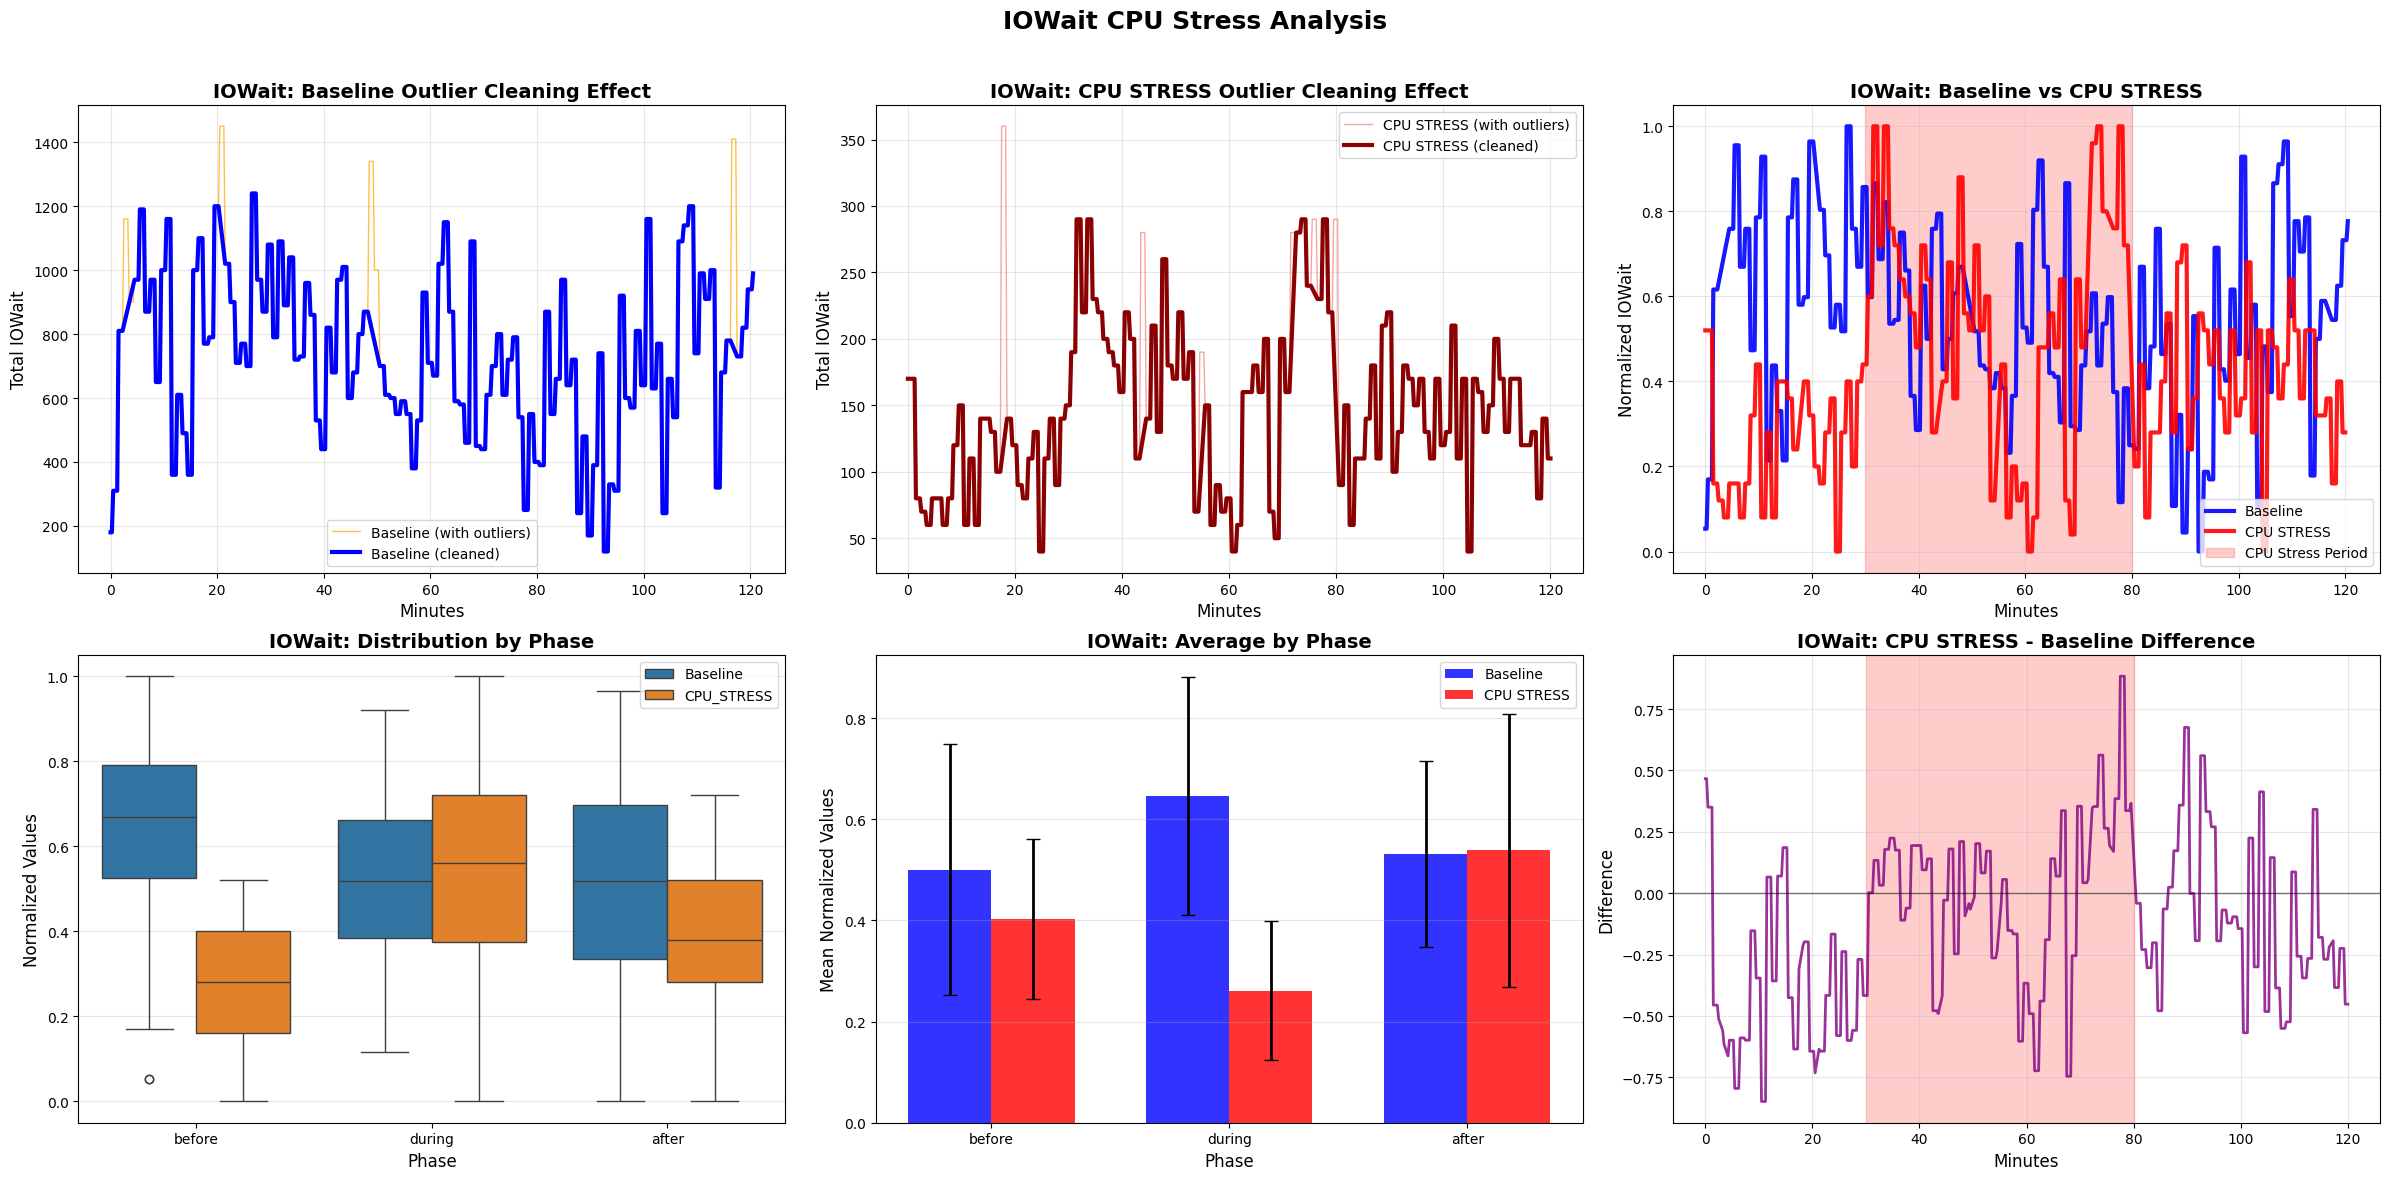


IOWAIT - CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5005  0.2483  0.0000  0.9643
before  0.6461  0.2346  0.0536  1.0000
during  0.5313  0.1842  0.1161  0.9196

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std  min   max
phase                            
after   0.4022  0.1581  0.0  0.72
before  0.2613  0.1367  0.0  0.52
during  0.5382  0.2707  0.0  1.00

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 15.53, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= -0.30, p=  0.7647 (❌ NOT SIGNIFICANT)
  AFTER   : t=  4.23, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -59.55% (↘️ DECREASE)
  DURING  :   +1.30% (↗️ INCREASE)
  AFTER   :  -19.65% (↘️ DECREASE)

🔄 Analyzing IRQ...


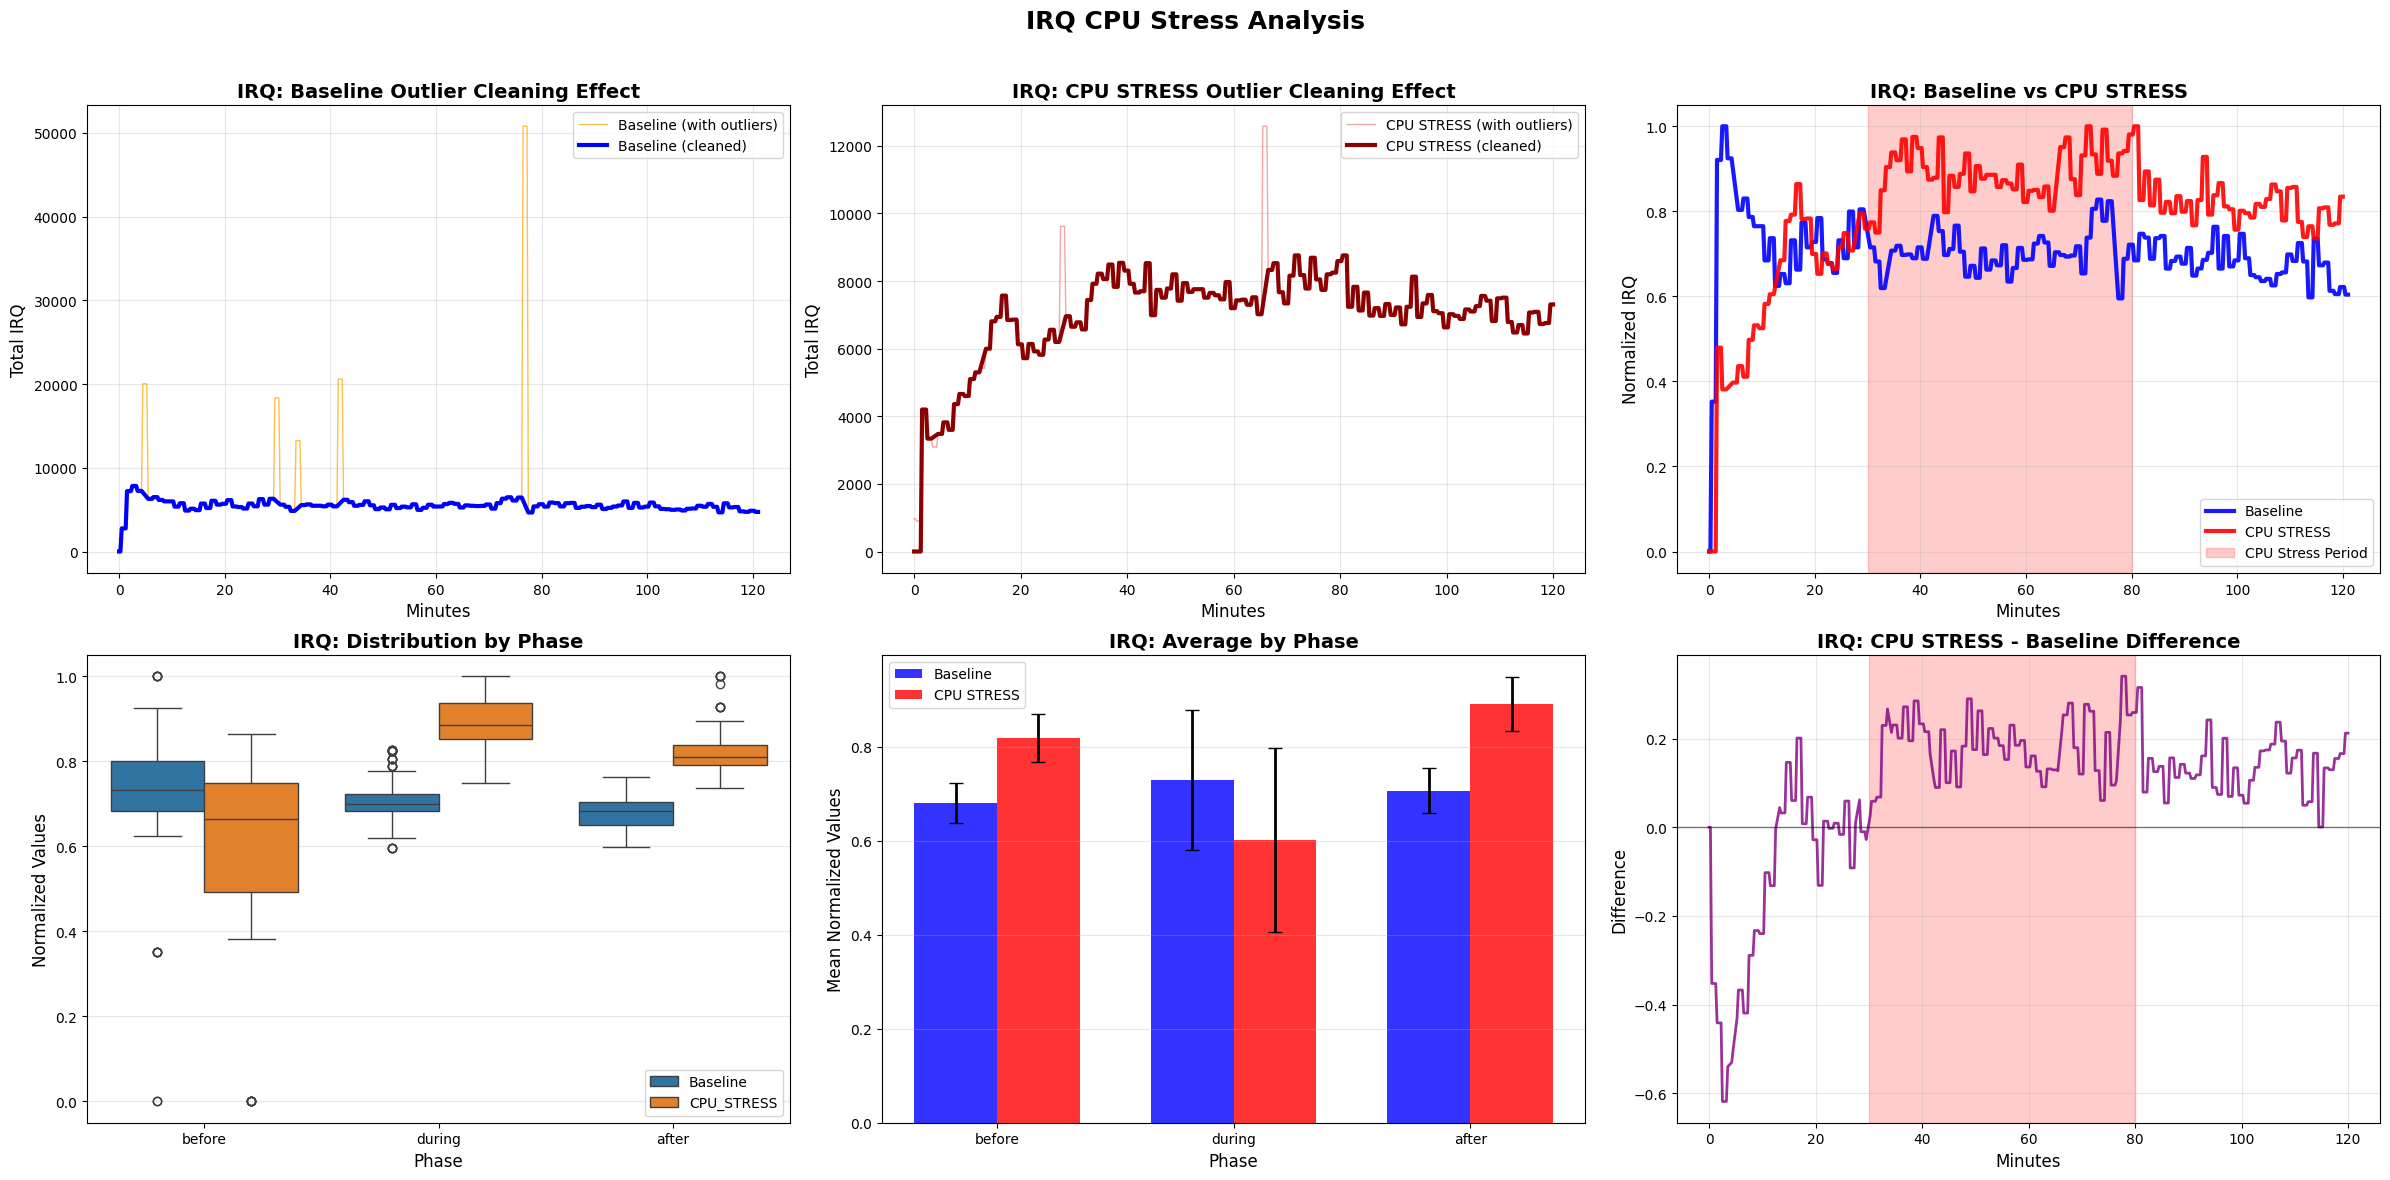


IRQ - CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.6803  0.0427  0.5977  0.7637
before  0.7296  0.1487  0.0000  1.0000
during  0.7058  0.0475  0.5951  0.8276

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.8189  0.0512  0.7363  1.0000
before  0.6019  0.1957  0.0000  0.8642
during  0.8904  0.0569  0.7500  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  5.69, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-35.30, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=-26.47, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -17.50% (↘️ DECREASE)
  DURING  :  +26.16% (↗️ INCREASE)
  AFTER   :  +20.38% (↗️ INCREASE)

🔄 Analyzing System...


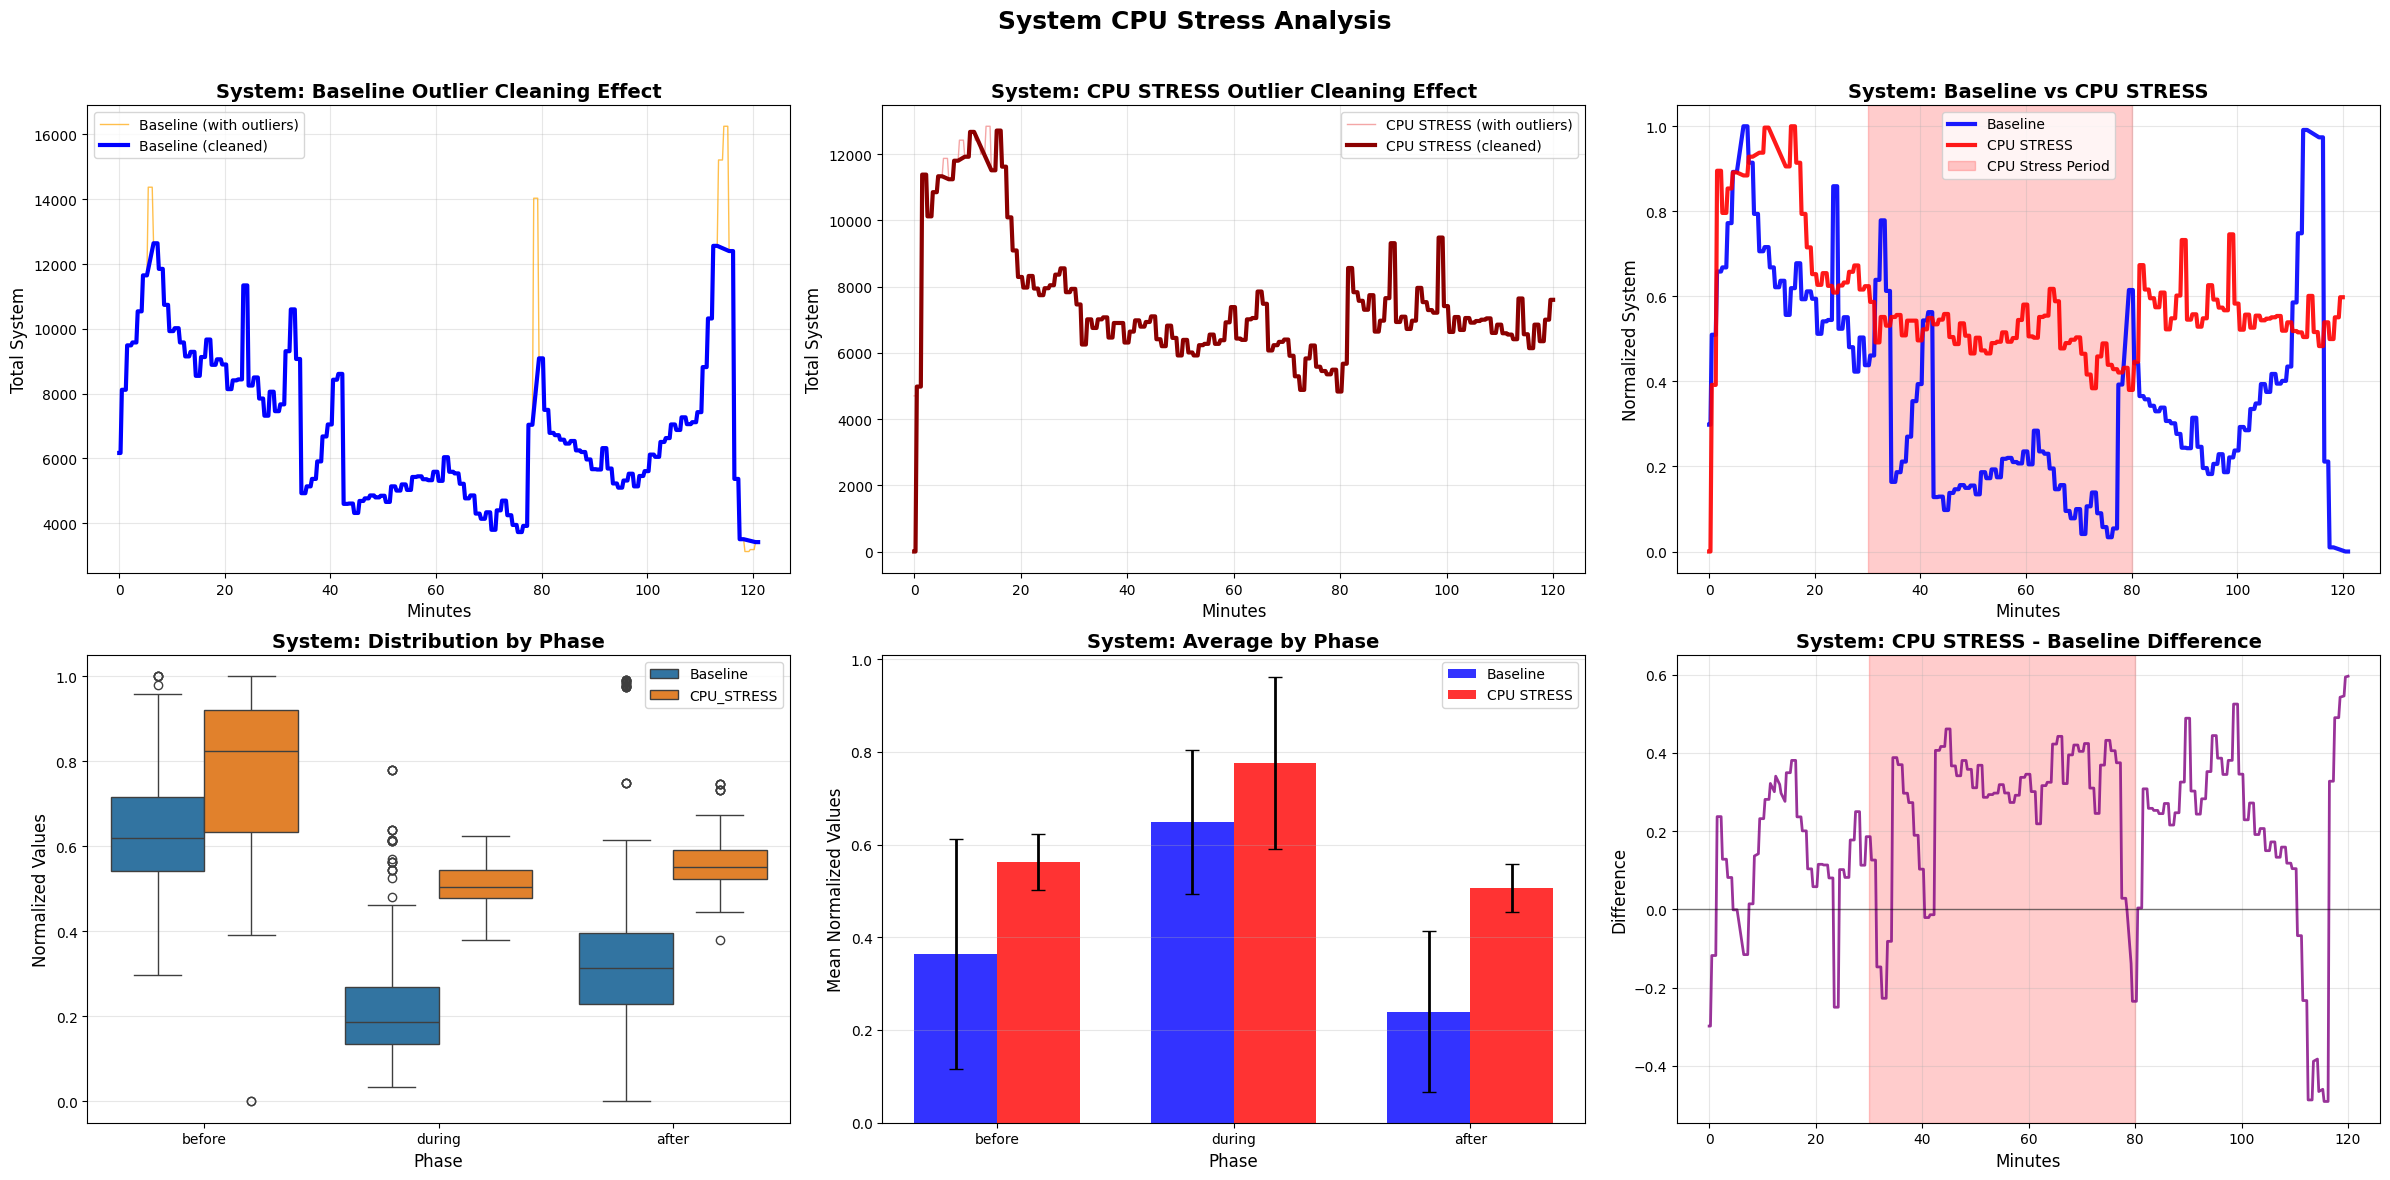


SYSTEM - CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3633  0.2484  0.0000  0.9913
before  0.6488  0.1556  0.2983  1.0000
during  0.2399  0.1734  0.0336  0.7787

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std   min     max
phase                               
after   0.5618  0.0600  0.38  0.7459
before  0.7755  0.1853  0.00  1.0000
during  0.5065  0.0513  0.38  0.6239

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -5.74, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-20.91, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= -9.83, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  +19.53% (↗️ INCREASE)
  DURING  : +111.18% (↗️ INCREASE)
  AFTER   :  +54.63% (↗️ INCREASE)

🔄 Analyzing User...


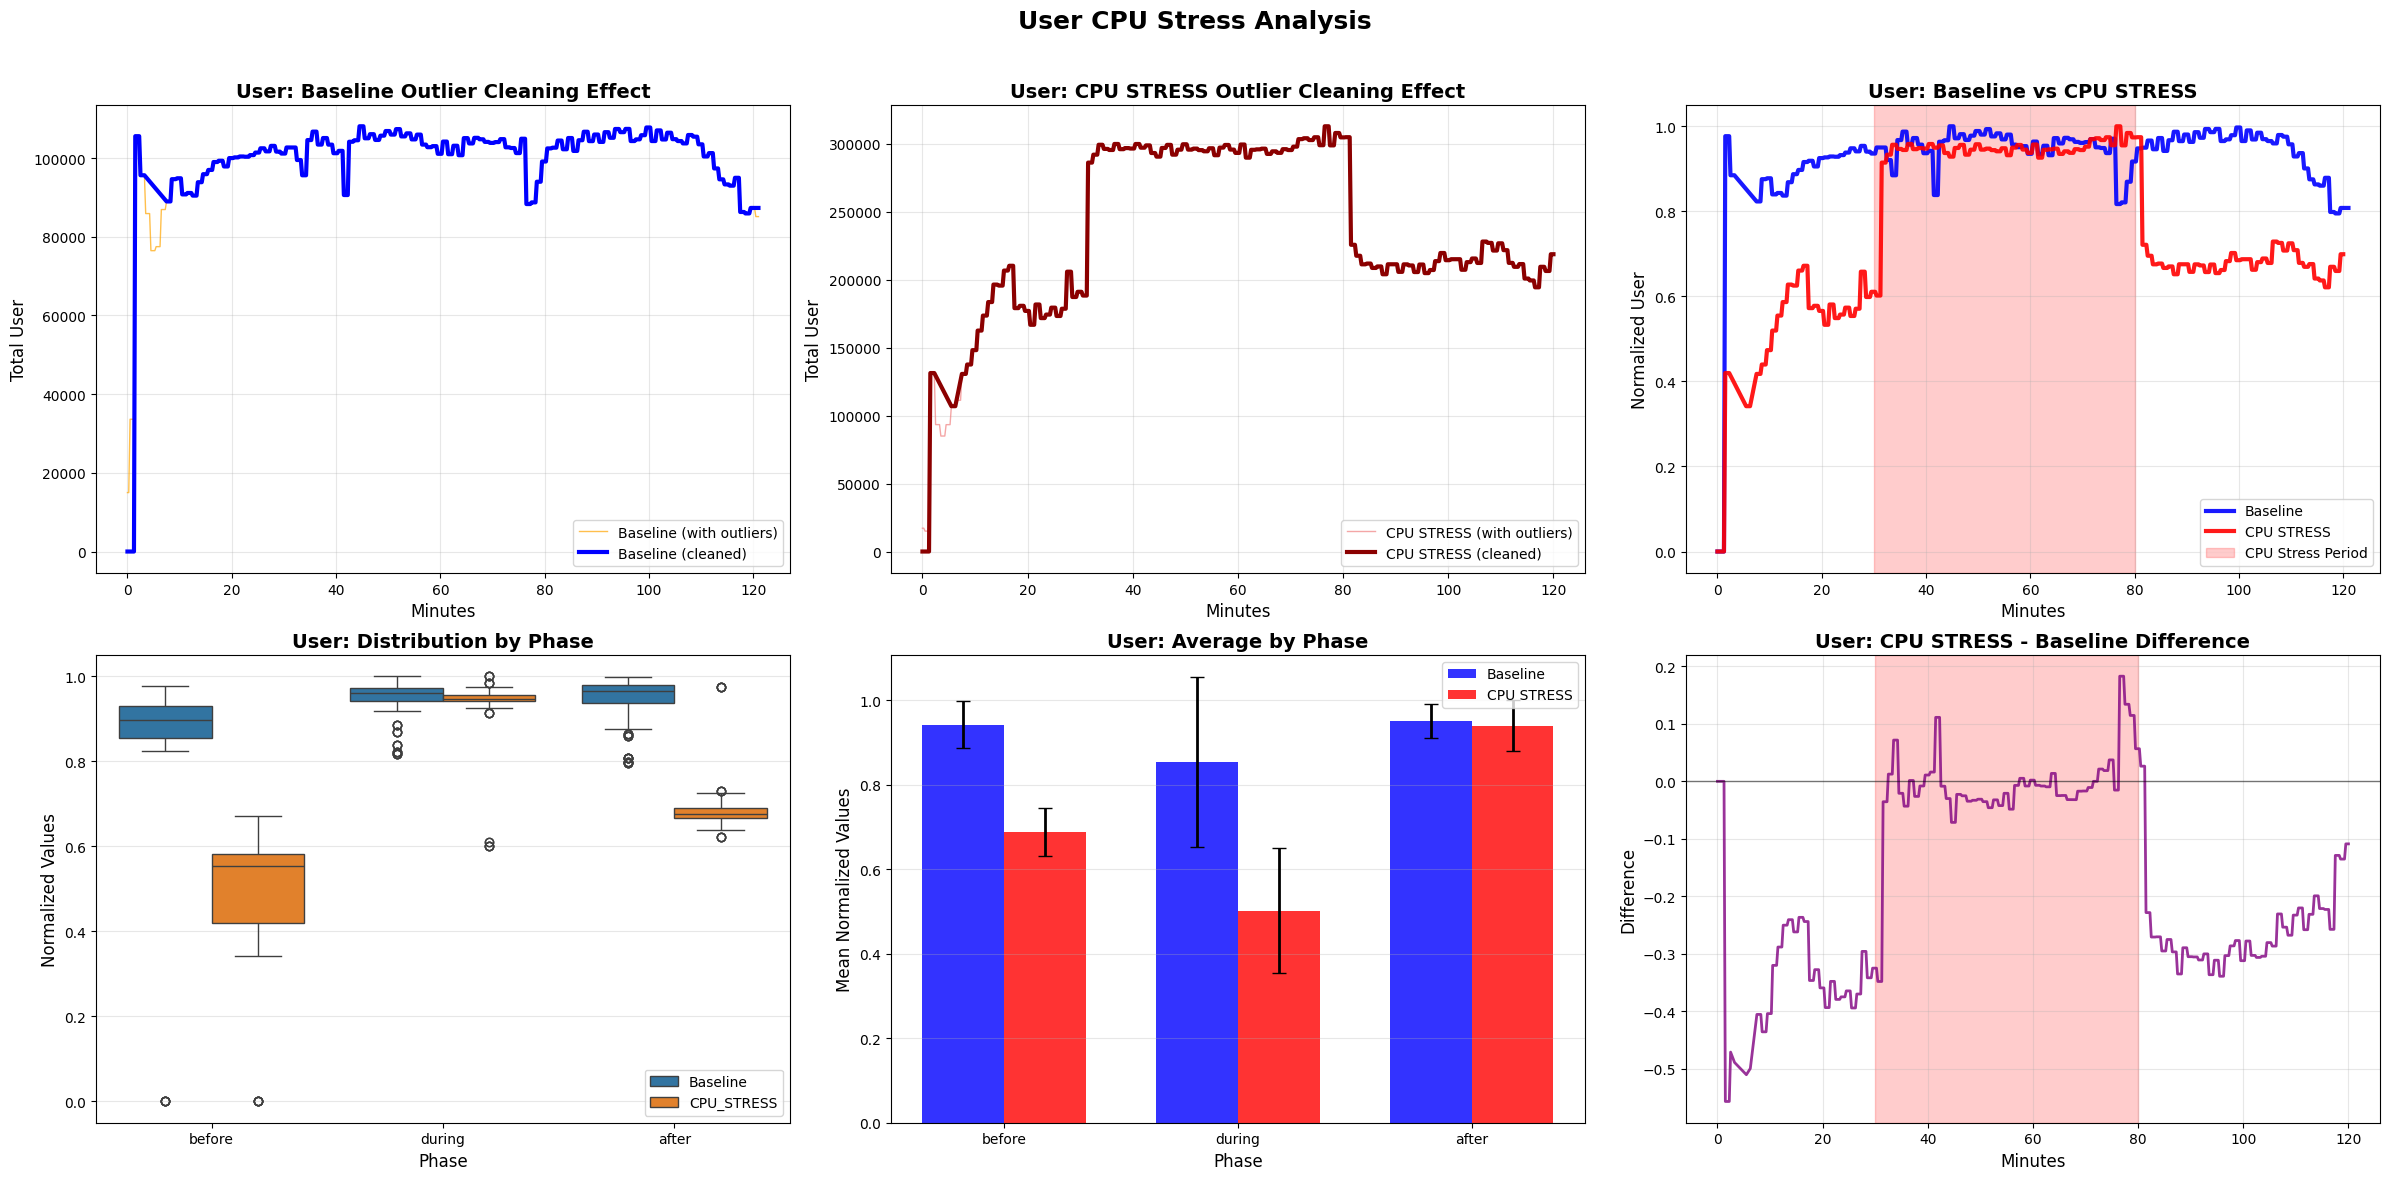


USER - CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9421  0.0564  0.7950  0.9971
before  0.8533  0.2008  0.0000  0.9767
during  0.9502  0.0397  0.8171  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.6878  0.0567  0.6213  0.9743
before  0.5019  0.1487  0.0000  0.6720
during  0.9394  0.0606  0.6019  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 15.41, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=  2.11, p=  0.0353 (✅ SIGNIFICANT)
  AFTER   : t= 40.50, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -41.18% (↘️ DECREASE)
  DURING  :   -1.14% (↘️ DECREASE)
  AFTER   :  -27.00% (↘️ DECREASE)

🔄 Analyzing Utilization...


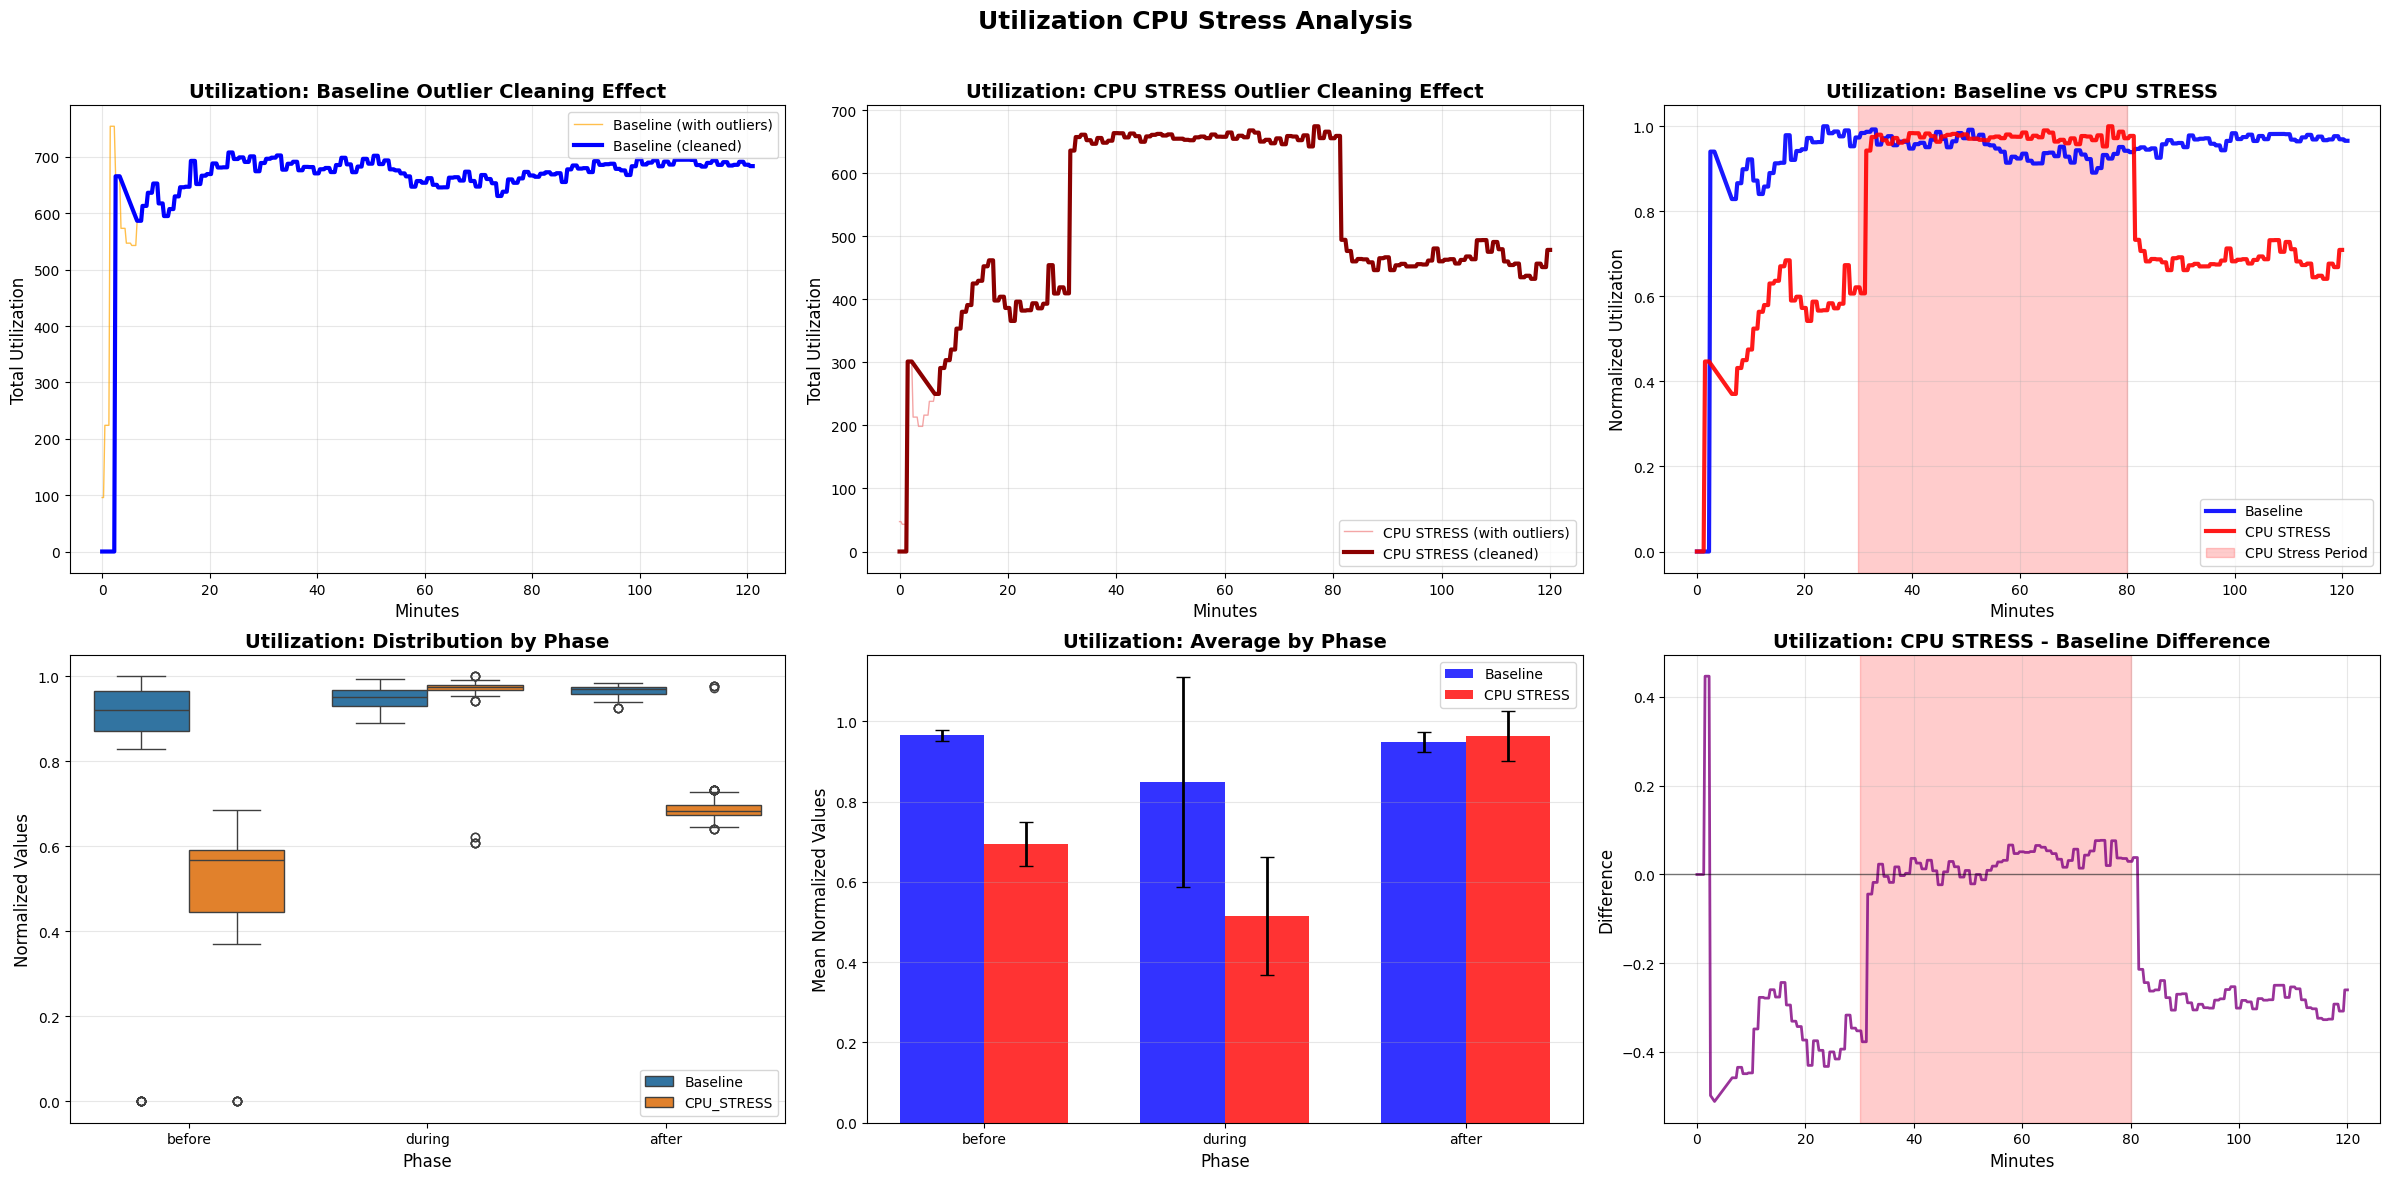


UTILIZATION - CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std    min     max
phase                                
after   0.9655  0.0134  0.926  0.9836
before  0.8487  0.2613  0.000  1.0000
during  0.9489  0.0247  0.891  0.9925

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.6948  0.0552  0.6412  0.9773
before  0.5151  0.1478  0.0000  0.6848
during  0.9627  0.0625  0.6071  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 12.17, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= -2.91, p=  0.0038 (✅ SIGNIFICANT)
  AFTER   : t= 60.99, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -39.31% (↘️ DECREASE)
  DURING  :   +1.45% (↗️ INCREASE)
  AFTER   :  -28.03% (↘️ DECREASE)


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all datasets
df_iowait = pd.read_csv("cpu_iowait.csv")
df_cpu_irq = pd.read_csv("cpu_irq.csv")
df_system_msec = pd.read_csv("cpu_system_msec.csv")
df_user_msec = pd.read_csv("cpu_user_msec.csv")
df_cpu_util = pd.read_csv("cpu_util_per.csv")

df_baseline_iowait = pd.read_csv("../../baseline/cpu related/cpu_iowait.csv")
df_baseline_irq = pd.read_csv("../../baseline/cpu related/cpu_irq.csv")
df_baseline_system_msec = pd.read_csv("../../baseline/cpu related/cpu_system_msec.csv")
df_baseline_user_msec = pd.read_csv("../../baseline/cpu related/cpu_user_msec.csv")
df_baseline_util_per = pd.read_csv("../../baseline/cpu related/cpu_util_per.csv")

# Add source labels
df_iowait["source"] = "CPU STRESS"
df_cpu_irq["source"] = "CPU STRESS"
df_system_msec["source"] = "CPU STRESS"
df_user_msec["source"] = "CPU STRESS"
df_cpu_util["source"] = "CPU STRESS"

df_baseline_iowait["source"] = "BASELINE"
df_baseline_irq["source"] = "BASELINE"
df_baseline_system_msec["source"] = "BASELINE"
df_baseline_user_msec["source"] = "BASELINE"
df_baseline_util_per["source"] = "BASELINE"

# Convert to datetime
df_iowait["Time"] = pd.to_datetime(df_iowait["Time"])
df_cpu_irq["Time"] = pd.to_datetime(df_cpu_irq["Time"])
df_system_msec["Time"] = pd.to_datetime(df_system_msec["Time"])
df_user_msec["Time"] = pd.to_datetime(df_user_msec["Time"])
df_cpu_util["Time"] = pd.to_datetime(df_cpu_util["Time"])

df_baseline_iowait["Time"] = pd.to_datetime(df_baseline_iowait["Time"])
df_baseline_irq["Time"] = pd.to_datetime(df_baseline_irq["Time"])
df_baseline_system_msec["Time"] = pd.to_datetime(df_baseline_system_msec["Time"]) 
df_baseline_user_msec["Time"] = pd.to_datetime(df_baseline_user_msec["Time"])
df_baseline_util_per["Time"] = pd.to_datetime(df_baseline_util_per["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_iowait["Time"].min() - df_iowait["Time"].min()
df_iowait["Time"] += time_offset
df_cpu_irq["Time"] += time_offset
df_system_msec["Time"] += time_offset
df_user_msec["Time"] += time_offset
df_cpu_util["Time"] += time_offset

# Convert timeline to minutes 
all_dfs = [
    df_iowait, df_cpu_irq, df_system_msec, df_user_msec, df_cpu_util,
    df_baseline_iowait, df_baseline_irq, df_baseline_system_msec, 
    df_baseline_user_msec, df_baseline_util_per
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# ORIGINAL DATASETS DICTIONARY 
original_datasets = {
    'IOWait': {'cpu_stress': df_iowait, 'baseline': df_baseline_iowait},
    'IRQ': {'cpu_stress': df_cpu_irq, 'baseline': df_baseline_irq},
    'System': {'cpu_stress': df_system_msec, 'baseline': df_baseline_system_msec},
    'User': {'cpu_stress': df_user_msec, 'baseline': df_baseline_user_msec},
    'Utilization': {'cpu_stress': df_cpu_util, 'baseline': df_baseline_util_per}
}

# ISOLATION FOREST OUTLIER DETECTION
def remove_outliers_isolation_forest(df, contamination=0.02):
    df_clean = df.copy()
    cpu_cols = [col for col in df.columns if col.startswith('cpu')]
    outlier_stats = {}
    
    if len(cpu_cols) == 0:
        return df_clean, outlier_stats
    
    feature_matrix = df[cpu_cols].values
    
    # missing values ffill
    if np.isnan(feature_matrix).any():
        feature_matrix = pd.DataFrame(feature_matrix).fillna(method='ffill').fillna(method='bfill').values
    
    # Scale features for better performance
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)
    
    # Initialize and fit Isolation Forest
    iso_forest = IsolationForest(
        contamination=contamination,
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    
    iso_forest.fit(feature_matrix_scaled)
    outlier_predictions = iso_forest.predict(feature_matrix_scaled)
    
    outlier_mask = outlier_predictions == -1
    
    # removal
    for col in cpu_cols:
        outlier_stats[col] = {
            'count': outlier_mask.sum(),
            'percentage': (outlier_mask.sum() / len(df[col])) * 100
        }
        
        # Set outliers to NaN and interpolate
        df_clean.loc[outlier_mask, col] = np.nan
        df_clean[col] = df_clean[col].interpolate(method='linear')

    outlier_stats['_summary'] = {
        'total_outliers': outlier_mask.sum(),
        'contamination_rate': contamination,
        'method': 'isolation_forest'
    }
    
    return df_clean, outlier_stats

# APPLY OUTLIER CLEANING
datasets_clean = {}
all_outlier_stats = {}

for dataset_name, dataset_pair in original_datasets.items():
    print(f"\n📊 Processing {dataset_name} with Isolation Forest:")
    
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        print(f"  🔍 {source_type.upper().replace('_', ' ')}:")
        
        # Apply Isolation Forest outlier detection
        df_clean, stats = remove_outliers_isolation_forest(df, contamination=0.05)
        
        datasets_clean[dataset_name][source_type] = df_clean
        all_outlier_stats[dataset_name][source_type] = stats
        
        # Print outlier summary
        total_outliers = stats['_summary']['total_outliers']
        print(f"    ✅ Cleaned {total_outliers} outliers (5% contamination rate)")

# NORMALIZATION FUNCTION
def normalize_df(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# ADD PHASE COLUMN
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# ANALYSIS AND PLOT FUNCTION (keeping all your original plots)
def analyze_and_plot_dataset_wide(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu')]
    
    cpu_stress_norm = normalize_df(cpu_stress_df, cpu_cols)
    baseline_norm = normalize_df(baseline_df, cpu_cols)
    
    # Calculate cumulative metrics
    cpu_stress_df['Total'] = cpu_stress_df[cpu_cols].sum(axis=1)
    baseline_df['Total'] = baseline_df[cpu_cols].sum(axis=1)
    
    # Normalize totals
    cpu_stress_norm['Total'] = (cpu_stress_df['Total'] - cpu_stress_df['Total'].min()) / (cpu_stress_df['Total'].max() - cpu_stress_df['Total'].min())
    baseline_norm['Total'] = (baseline_df['Total'] - baseline_df['Total'].min()) / (baseline_df['Total'].max() - baseline_df['Total'].min())
    
    # Add phase information
    cpu_stress_norm = add_phase_column(cpu_stress_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis
    stats_baseline = baseline_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    stats_cpu_stress = cpu_stress_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm['Total'],
        'CPU_STRESS': cpu_stress_norm['Total'],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': cpu_stress_norm['Total'] - baseline_norm['Total']
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['CPU_STRESS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        cpu_stress_mean = stats_cpu_stress.loc[phase, 'mean']
        impact[phase] = ((cpu_stress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # PLOTTING 
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline outlier cleaning effect
    plt.subplot(2, 3, 1)
    original_baseline = original_datasets[dataset_name]['baseline']
    
    plt.plot(original_baseline['Minutes'], original_baseline[cpu_cols].sum(axis=1), 
             label='Baseline (with outliers)', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df['Minutes'], baseline_df['Total'], 
             label='Baseline (cleaned)', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. CPU STRESS outlier cleaning effect
    plt.subplot(2, 3, 2)
    original_cpu_stress = original_datasets[dataset_name]['cpu_stress']
    
    plt.plot(original_cpu_stress['Minutes'], original_cpu_stress[cpu_cols].sum(axis=1), 
             label='CPU STRESS (with outliers)', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(cpu_stress_df['Minutes'], cpu_stress_df['Total'], 
             label='CPU STRESS (cleaned)', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: CPU STRESS Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm['Total'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(cpu_stress_norm['Minutes'], cpu_stress_norm['Total'], 
             label='CPU STRESS', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    plt.title(f"{dataset_name}: Baseline vs CPU STRESS", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {dataset_name}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'CPU_STRESS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_cpu_stress['mean'], width, label='CPU STRESS', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_cpu_stress['mean'], yerr=stats_cpu_stress['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: CPU STRESS - Baseline Difference', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} CPU Stress Analysis', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    # Print statistical results
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - CPU STRESS ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 CPU STRESS STATISTICS BY PHASE:")
    print(stats_cpu_stress.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 CPU STRESS IMPACT (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_cpu_stress': stats_cpu_stress,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined
    }

# RUN ANALYSIS 
print(f"\n{'='*80}")
print("COMPREHENSIVE CPU STRESS ANALYSIS - ISOLATION FOREST")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name}...")
    
    cpu_stress_clean = datasets_clean[dataset_name]['cpu_stress']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_dataset_wide(
        dataset_name, 
        cpu_stress_clean, 
        baseline_clean, 
        delay, 
        duration
    )